#Import dependencies#

In [ ]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy import stats
from sklearn import metrics
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold,LeaveOneOut,cross_val_score,cross_validate
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.tree import DecisionTreeClassifier


import warnings
warnings.filterwarnings("ignore")

#Read data#

In [ ]:
df=pd.read_csv("complete_acac_lig_dataset.csv")

#Features from the selected M4 model#
Selection of the four (M4) contributing features
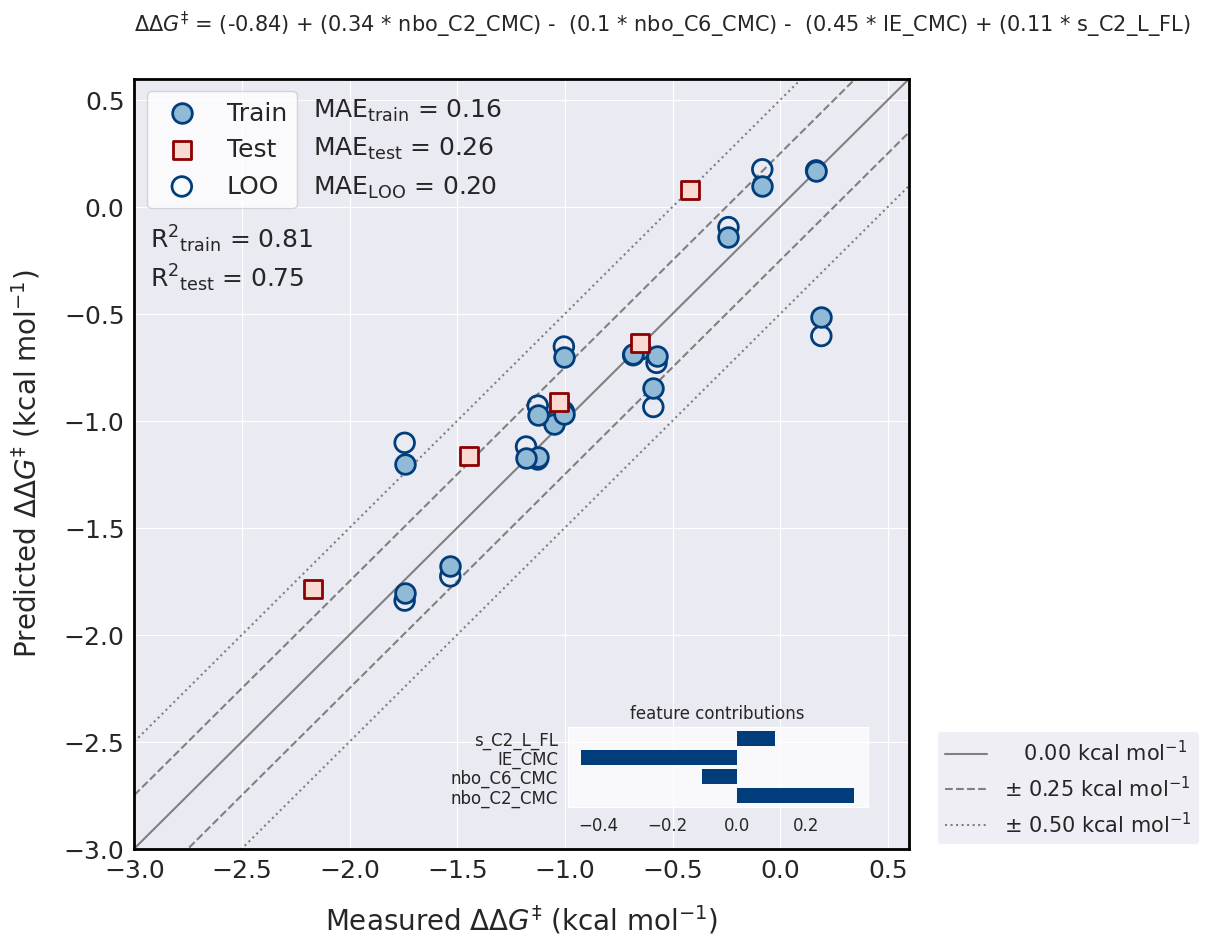

In [ ]:
# Selecting features from the M4 model
selected_features = ['nbo_C2_CMC', 'nbo_C6_CMC', 's_C2_L_FL']
feature_unit = ['e', 'e', 'Å'] # For plotting purpose

# Labels for the target classes
target_names = ['0 ("negatives")', '1 ("positives")']

# Define marker shapes for enol(X=C) and amide(X=N) ligand type
marker_shapes = {'enol': 'o', 'amide': 's'}

#Ligand's reactivity classification#

In [ ]:
# Calculate mean and median from yield distribution
mean_yield = df['exp_yield'].mean()
median_yield = df['exp_yield'].median()

print(f"Mean yield = {mean_yield:.2f} %")
print(f"Median yield = {median_yield:.2f} %")

Mean yield = 40.73 %
Median yield = 35.00 %


**Note:** The following code segment is a modified version of the original script from Newman-Stonebraker et al.'s reported work.


*   Reference article: Newman-Stonebraker, S. H.; Smith, S. R.; Borowski, J. E.; Peters, E.; Gensch, T.; Johnson, H. C.; Sigman, M. S.; Doyle, A. G. Univariate Classification of Phosphine Ligation State and Reactivity in Cross-Coupling Catalysis. *Science* **2021**, *374*, 301-308, DOI: [10.1126/science.abj4213](https://www.science.org/doi/10.1126/science.abj4213)
*   Reference script: https://github.com/sigmangroup/threshold





Feature: nbo_C2_CMC
Min: 0.36613, Max: 0.69386, Unique values: 22
Class balance: [11 11]
Decision threshold = 0.57
Accuracy: 0.91
F1 Score: 0.92
Recall: 1.00
Classification Report: 
                 precision    recall  f1-score   support

0 ("negatives")       1.00      0.82      0.90        11
1 ("positives")       0.85      1.00      0.92        11

       accuracy                           0.91        22
      macro avg       0.92      0.91      0.91        22
   weighted avg       0.92      0.91      0.91        22

------------------------------------------------------------
xx.shape: (7560, 36), yy.shape: (7560, 36)
Z.shape: (7560, 36)


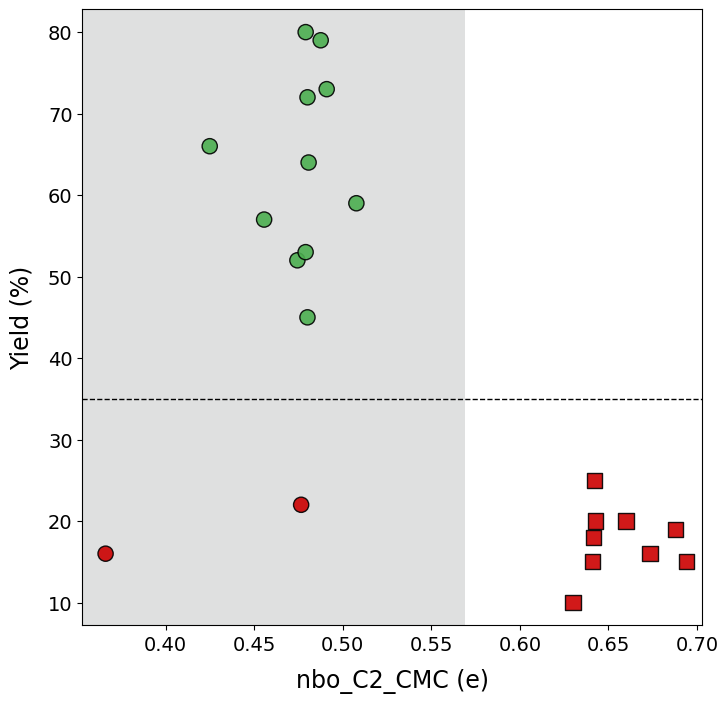







Feature: nbo_C6_CMC
Min: -0.09674, Max: -0.0645, Unique values: 21
Class balance: [11 11]
Decision threshold = -0.07
Accuracy: 0.82
F1 Score: 0.85
Recall: 1.00
Classification Report: 
                 precision    recall  f1-score   support

0 ("negatives")       1.00      0.64      0.78        11
1 ("positives")       0.73      1.00      0.85        11

       accuracy                           0.82        22
      macro avg       0.87      0.82      0.81        22
   weighted avg       0.87      0.82      0.81        22

------------------------------------------------------------
xx.shape: (7560, 4), yy.shape: (7560, 4)
Z.shape: (7560, 4)


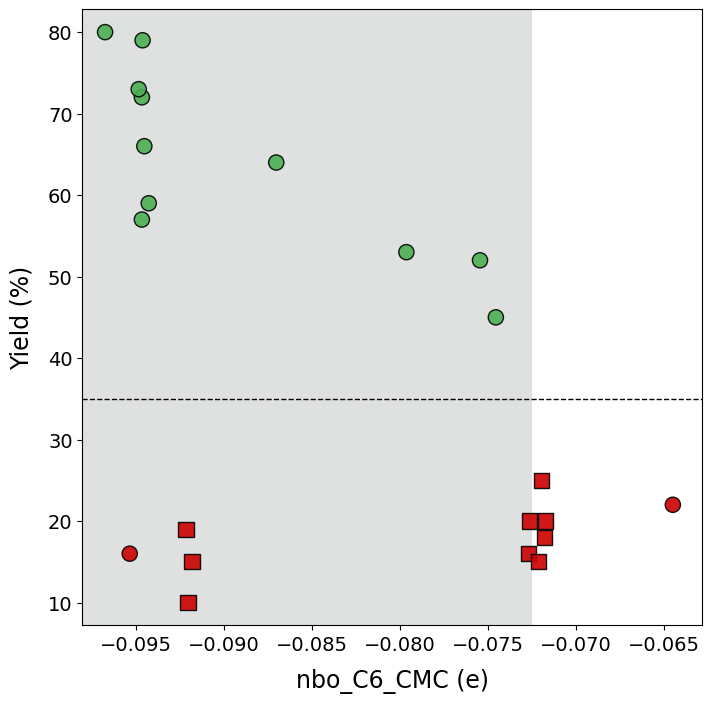







Feature: s_C2_L_FL
Min: 3.15, Max: 8.55, Unique values: 12
Class balance: [11 11]
Decision threshold = 6.42
Accuracy: 0.73
F1 Score: 0.77
Recall: 0.91
Classification Report: 
                 precision    recall  f1-score   support

0 ("negatives")       0.86      0.55      0.67        11
1 ("positives")       0.67      0.91      0.77        11

       accuracy                           0.73        22
      macro avg       0.76      0.73      0.72        22
   weighted avg       0.76      0.73      0.72        22

------------------------------------------------------------
xx.shape: (7560, 584), yy.shape: (7560, 584)
Z.shape: (7560, 584)


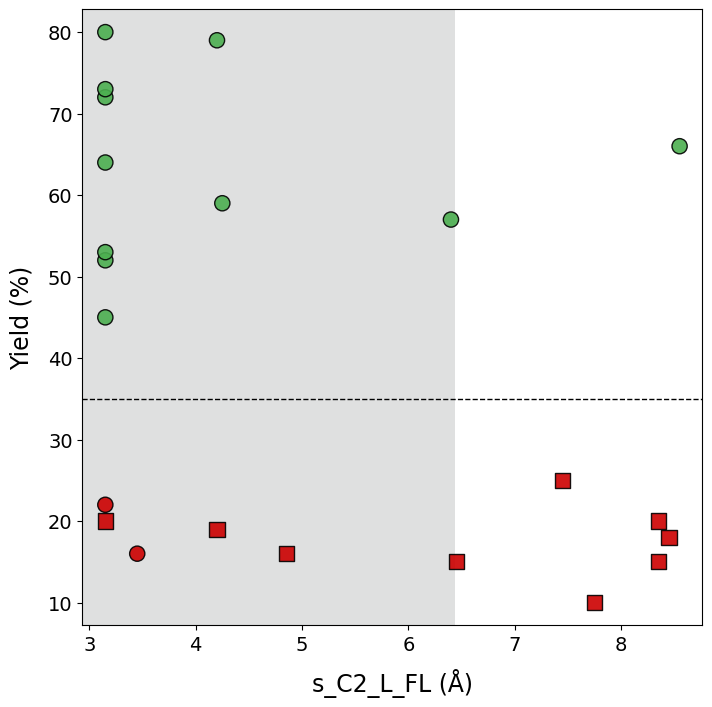

In [ ]:
# Threshold analysis for selected features

# Yield cutoff to define ligand's reactivity as acceptable/unacceptable for the reaction
y_cut = median_yield

for i, feature in enumerate(selected_features):

    # Read in data
    y_all = df['exp_yield'].dropna()  # Experimental yield data
    X_all = df[feature].loc[y_all.index].values
    ligand_types = df['ligand_type'].loc[y_all.index]  # For enol(X=C) and amide(X=N) ligand type

    # Print feature statistics
    print(f"Feature: {feature}")
    print(f"Min: {X_all.min()}, Max: {X_all.max()}, Unique values: {len(np.unique(X_all))}")

    # Use the complete dataset for threshold analysis
    X_use = X_all
    y_use = y_all
    ligand_use = ligand_types

    # Binarize the yield based on the set threshold value
    y_class = np.array([0 if i < y_cut else 1 for i in y_use])

    # Check class balance
    print(f"Class balance: {np.bincount(y_class)}")

    # Checking for having at least two classes
    if len(np.unique(y_class)) > 1:

        # Fiting a decision tree classifier with balanced class weights
        dt = DecisionTreeClassifier(max_depth=1, class_weight='balanced')
        dt.fit(X_use.reshape(-1, 1), y_class)

        # Print metrics and decision threshold
        print(f"Decision threshold = {dt.tree_.threshold[0]:.2f}")
        print(f"Accuracy: {dt.score(X_use.reshape(-1, 1), y_class):.2f}")
        print(f"F1 Score: {metrics.f1_score(y_class, dt.predict(X_use.reshape(-1, 1))):.2f}")
        print(f"Recall: {metrics.recall_score(y_class, dt.predict(X_use.reshape(-1, 1)), pos_label=1, average='binary'):.2f}")
        print(f"Classification Report: \n{metrics.classification_report(y_class, dt.predict(X_use.reshape(-1, 1)), target_names=target_names)}")
        print('-' * 60)

        # For plotting
        plot_step = 0.01
        x_min, x_max = X_all.min(), X_all.max()
        y_min, y_max = y_all.min(), y_all.max()

        cMap_background = ListedColormap(['white', '#dfe0e0'])# Background(region) color: white(negative) and green(positive)
        cMap_points = ListedColormap(["#c00", "#4caf50"])# Ligand(marker) color: red(unacceptable) and green(acceptable)

        # Ideal classification case: All green markers in green region and all red markers in white region

        dx, dy = x_max - x_min, y_max - y_min
        xx, yy = np.meshgrid(np.arange(x_min - 0.04 * dx, x_max + 0.04 * dx, plot_step),
                             np.arange(y_min - 0.04 * dy, y_max + 0.04 * dy, plot_step))

        # For cross reference
        print(f'xx.shape: {xx.shape}, yy.shape: {yy.shape}')

        plt.figure(figsize=(8, 8))
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

        # Predict on the mesh grid
        Z = dt.predict(xx.ravel().reshape(-1, 1))
        Z = Z.reshape(xx.shape)

        # For cross reference
        print(f'Z.shape: {Z.shape}')

        plt.contourf(xx, yy, Z, cmap=cMap_background)

        plt.xlabel(f"{feature} ({feature_unit[i]})", fontsize=17, labelpad=10)
        plt.ylabel("Yield (%)", fontsize=17, labelpad=10)

        # Scatter plot with different marker shapes for enol(X=C) and amide(X=N) ligand type
        for ligand_type in np.unique(ligand_use):
            mask = ligand_use == ligand_type
            plt.scatter(X_use[mask], y_use[mask], c=y_class[mask], cmap=cMap_points, alpha=0.9, edgecolor="black", s=120,
                        marker=marker_shapes[ligand_type], label=ligand_type, linewidths=1)

        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)

        # Horizontal dashed line for cutoff indicator
        plt.axhline(y=y_cut, color='black', linestyle='--', linewidth=1.0)

        # plt.legend(title="Ligand Type", fontsize=15)
        plt.show()
        print('\n'*5)

    else:
        print(f"Classification for feature {feature} not possible at the considered cutoff.")
        print('\n'*5)


**Note:** Since the feature scale of the feature IE_CMC was very narrowly ranged, the above approach was modified for the 2D space. An appropriate meshgrid range for IE_CMC was mannually set.

Feature: IE_CMC
Min: -0.003517781, Max: 0.003219379, Unique values: 22
Class balance: [11 11]
Decision threshold = -0.001
Accuracy: 0.68
F1 Score: 0.67
Recall: 0.64
Classification Report: 
                 precision    recall  f1-score   support

0 ("negatives")       0.67      0.73      0.70        11
1 ("positives")       0.70      0.64      0.67        11

       accuracy                           0.68        22
      macro avg       0.68      0.68      0.68        22
   weighted avg       0.68      0.68      0.68        22

------------------------------------------------------------
xx.shape: (800000, 88), yy.shape: (800000, 88)
Z.shape: (800000, 88)


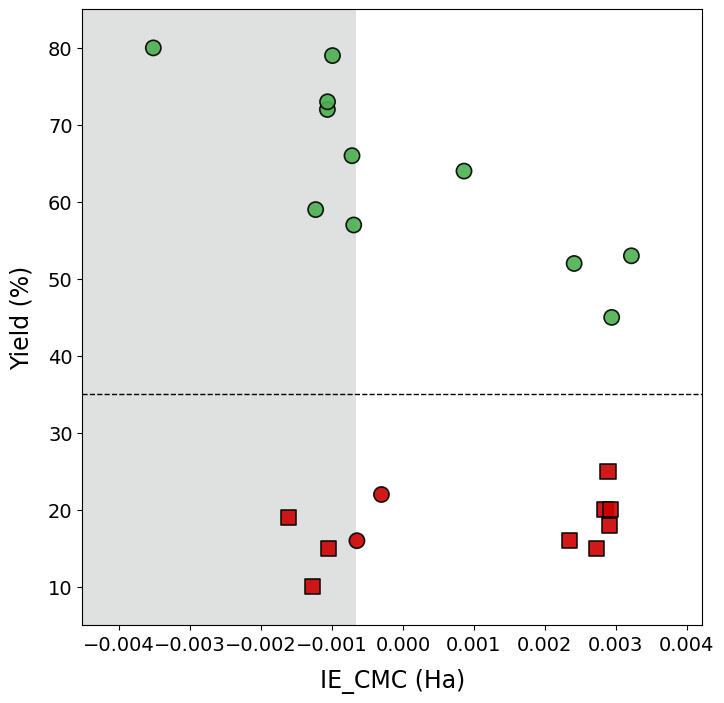

In [ ]:
# For the specific feature to analyze
feature = 'IE_CMC'


y_all = df['exp_yield'].dropna()
X_all = df[feature].loc[y_all.index].values
ligand_types = df['ligand_type'].loc[y_all.index]

print(f"Feature: {feature}")
print(f"Min: {X_all.min()}, Max: {X_all.max()}, Unique values: {len(np.unique(X_all))}")

X_use = X_all
y_use = y_all
ligand_use = ligand_types

y_class = np.array([0 if i < y_cut else 1 for i in y_use])

print(f"Class balance: {np.bincount(y_class)}")


if len(np.unique(y_class)) > 1:
    dt = DecisionTreeClassifier(max_depth=1, class_weight='balanced')
    dt.fit(X_use.reshape(-1, 1), y_class)

    print(f"Decision threshold = {dt.tree_.threshold[0]:.3f}") # For threshold value upto 3 decimal places
    print(f"Accuracy: {dt.score(X_use.reshape(-1, 1), y_class):.2f}")
    print(f"F1 Score: {metrics.f1_score(y_class, dt.predict(X_use.reshape(-1, 1))):.2f}")
    print(f"Recall: {metrics.recall_score(y_class, dt.predict(X_use.reshape(-1, 1)), pos_label=1, average='binary'):.2f}")
    print(f"Classification Report: \n{metrics.classification_report(y_class, dt.predict(X_use.reshape(-1, 1)), target_names=target_names)}")
    print('-' * 60)

    # Adjustment of the plot_step for narrow range
    plot_step = 0.0001
    x_min, x_max = X_all.min() - 0.001, X_all.max() + 0.001  # Addition of smaller buffer
    y_min, y_max = y_all.min() - 5, y_all.max() + 5


    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    print(f'xx.shape: {xx.shape}, yy.shape: {yy.shape}')

    plt.figure(figsize=(8, 8))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = dt.predict(xx.ravel().reshape(-1, 1))
    Z = Z.reshape(xx.shape)

    print(f'Z.shape: {Z.shape}')

    plt.contourf(xx, yy, Z, cmap=cMap_background)

    plt.xlabel(f"{feature} (Ha)", fontsize=17, labelpad=10)
    plt.ylabel("Yield (%)", fontsize=17, labelpad=10)

    for ligand_type in np.unique(ligand_use):
        mask = ligand_use == ligand_type
        plt.scatter(X_use[mask], y_use[mask], c=y_class[mask], cmap=cMap_points, alpha=0.9, edgecolor="black", s=120,
                    marker=marker_shapes[ligand_type], label=ligand_type, linewidths=1.2)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.axhline(y=y_cut, color='black', linestyle='--', linewidth=1.0)

    # plt.legend(title="Ligand Type", fontsize=15)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.show()
    print('\n'*5)

else:
    print(f"Classification for feature {feature} not possible at the considered cutoff.")
    print('\n'*5)

Feature: IE_CMC
Min: -2.2074392375290004, Max: 2.020189296911, Unique values: 22
Class balance: [11 11]
Decision threshold = -0.421
Accuracy: 0.68
F1 Score: 0.67
Recall: 0.64
Classification Report: 
                 precision    recall  f1-score   support

0 ("negatives")       0.67      0.73      0.70        11
1 ("positives")       0.70      0.64      0.67        11

       accuracy                           0.68        22
      macro avg       0.68      0.68      0.68        22
   weighted avg       0.68      0.68      0.68        22

------------------------------------------------------------
xx.shape: (8000, 443), yy.shape: (8000, 443)
Z.shape: (8000, 443)


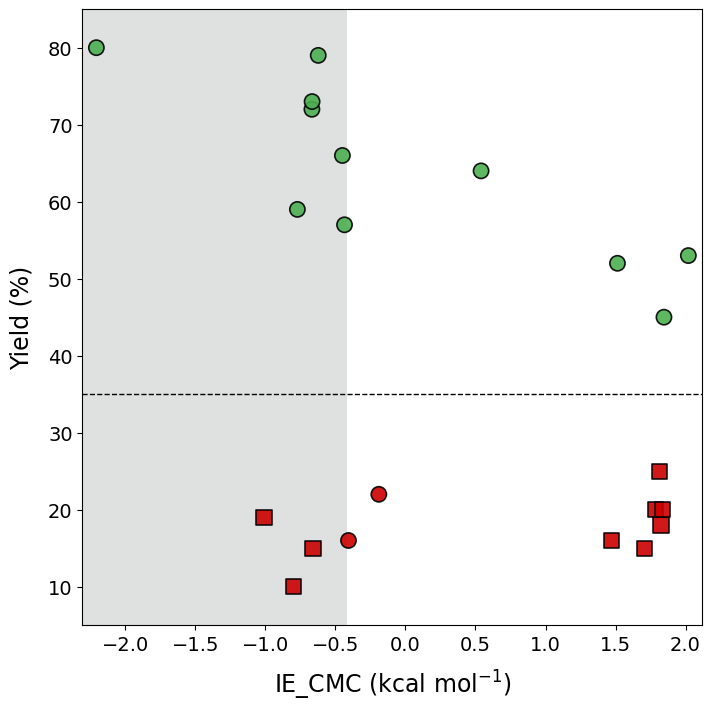

In [ ]:
# For the specific feature to analyze
feature = 'IE_CMC'


y_all = df['exp_yield'].dropna()
# X_all = df[feature].loc[y_all.index].values
X_all = df[feature].loc[df['exp_yield'].dropna().index].values*627.509 # converting IE's scale from unit Ha to kcal/mol (1 Ha = 627.509 kcal/mol)
ligand_types = df['ligand_type'].loc[y_all.index]

print(f"Feature: {feature}")
print(f"Min: {X_all.min()}, Max: {X_all.max()}, Unique values: {len(np.unique(X_all))}")

X_use = X_all
y_use = y_all
ligand_use = ligand_types

y_class = np.array([0 if i < y_cut else 1 for i in y_use])

print(f"Class balance: {np.bincount(y_class)}")


if len(np.unique(y_class)) > 1:
    dt = DecisionTreeClassifier(max_depth=1, class_weight='balanced')
    dt.fit(X_use.reshape(-1, 1), y_class)

    print(f"Decision threshold = {dt.tree_.threshold[0]:.3f}") # For threshold value upto 3 decimal places
    print(f"Accuracy: {dt.score(X_use.reshape(-1, 1), y_class):.2f}")
    print(f"F1 Score: {metrics.f1_score(y_class, dt.predict(X_use.reshape(-1, 1))):.2f}")
    print(f"Recall: {metrics.recall_score(y_class, dt.predict(X_use.reshape(-1, 1)), pos_label=1, average='binary'):.2f}")
    print(f"Classification Report: \n{metrics.classification_report(y_class, dt.predict(X_use.reshape(-1, 1)), target_names=target_names)}")
    print('-' * 60)

    # Adjustment of the plot_step for narrow range
    plot_step = 0.01  # adjusting step for kcal/mol scale
    x_min, x_max = X_all.min() - 0.1, X_all.max() + 0.1  # adjusting buffer for kcal/mol scale
    y_min, y_max = y_all.min() - 5, y_all.max() + 5


    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    print(f'xx.shape: {xx.shape}, yy.shape: {yy.shape}')

    plt.figure(figsize=(8, 8))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = dt.predict(xx.ravel().reshape(-1, 1))
    Z = Z.reshape(xx.shape)

    print(f'Z.shape: {Z.shape}')

    plt.contourf(xx, yy, Z, cmap=cMap_background)

    plt.xlabel(f"{feature} " r"(kcal mol$^{-1}$)", fontsize=17, labelpad=10)
    plt.ylabel("Yield (%)", fontsize=17, labelpad=10)

    for ligand_type in np.unique(ligand_use):
        mask = ligand_use == ligand_type
        plt.scatter(X_use[mask], y_use[mask], c=y_class[mask], cmap=cMap_points, alpha=0.9, edgecolor="black", s=120,
                    marker=marker_shapes[ligand_type], label=ligand_type, linewidths=1.2)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.axhline(y=y_cut, color='black', linestyle='--', linewidth=1.0)

    # plt.legend(title="Ligand Type", fontsize=15)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.show()
    print('\n'*5)

else:
    print(f"Classification for feature {feature} not possible at the considered cutoff.")
    print('\n'*5)